# CIFAR-10 dataset Image Classification using AutoEncoder as Feature Extractor

A) The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. * There are 50000 training images and 10000 test images.

B)     The dataset is divided into five training batches and one test batch, each with 10000 images.

C)     The test batch contains exactly 1000 randomly-selected images from each class.

D)     The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

E)     These are the classes in the dataset:

        1. airplane
        2. automobile
        3. bird
        4. cat
        5. deer
        6. dog
        7. frog
        8. horse
        9. ship
        10.truck

F) The classes are completely mutually exclusive. i.e. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

---

##### Import Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
import time
from torch.utils.data import Subset
import matplotlib.pyplot as plt

##### Check if CUDA is availaible

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if not device:
    print(device, ' :: CUDA is not available. Training on CPU ...')
else:
    print(device, ' :: CUDA is available! Training on GPU')
    
print("GPU :: Available :",torch.cuda.device_count())
print("\nGPU ::",torch.cuda.get_device_name())
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda:0' else {}


cuda:0  :: CUDA is available! Training on GPU
GPU :: Available : 1

GPU :: NVIDIA GeForce RTX 3090


##### hyper parameter

In [3]:
batch_size = 512
# num_epochs = 30
learning_rate = 0.01

##### Load CIFAR-10 dataset

In [4]:
transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



# load training dataset 50000 images 5000 for each class(total 10 class)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, **kwargs)
# Load test dataset 10000 images , 1000 for each class
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, **kwargs)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


##### check classes in the dataset

In [5]:
idx2class = {v: k for k, v in trainset.class_to_idx.items()}
idx2class

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

##### check images avialable for each image classes

In [6]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict
print("Distribution of classes: \n", get_class_distribution(trainset))


Distribution of classes: 
 {'airplane': 5000, 'automobile': 5000, 'bird': 5000, 'cat': 5000, 'deer': 5000, 'dog': 5000, 'frog': 5000, 'horse': 5000, 'ship': 5000, 'truck': 5000}


---
#### Selecting imbalanced dataset for training

we want **bird=deer=truck=2500** images for training that is 50% of the training images per class in the training dataset i.e. 5000.

In [7]:
bird_indices, deer_indices, truck_indices, other_indices = [], [], [], []
bird_idx, deer_idx, truck_idx = trainset.class_to_idx['bird'], trainset.class_to_idx['deer'], trainset.class_to_idx['truck']

for i in range(len(trainset)):
  current_class = trainset[i][1]
  if current_class == bird_idx:
    bird_indices.append(i)
  elif current_class == deer_idx:
    deer_indices.append(i)
  elif current_class == truck_idx:
    truck_indices.append(i)
  else:
    other_indices.append(i)
    
#select the number of images required for training in our case its 50%
#therefore 0.5* len(xx_indices)
bird_indices = bird_indices[:int(0.5 * len(bird_indices))]
deer_indices = deer_indices[:int(0.5 * len(deer_indices))]
truck_indices = truck_indices[:int(0.5 * len(truck_indices))]
new_dataset = Subset(trainset, bird_indices+deer_indices+truck_indices+other_indices)


##### Load the new created subset into the Dataloader for training

In [8]:
newtrainloader = torch.utils.data.DataLoader(new_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

##### length of the training and testing data

In [9]:
# print("Old train set ::",trainset)
print("Old train set ::",len(trainset))


# print("New train set ::",new_dataset)
print("New train set ::",len(new_dataset))

# print("test loader ::",testset)
print("test set ::",len(testset))

Old train set :: 50000
New train set :: 42500
test set :: 10000


##### Plotting Images

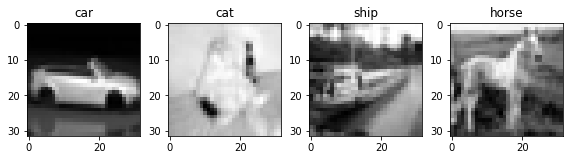

In [10]:
# get some random training images
dataiter = iter(newtrainloader)
images, labels = dataiter.next()
images = images.numpy()
# plotting first 64 images
fig = plt.figure(figsize=(8,8))

for i in range(4):
    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(images[i][0],  cmap = 'gray')#cmap = plt.cm.bone)
    ax.set_title(classes[labels[i]])
plt.tight_layout()
plt.show()

---
### Network model

##### Autoencoder model

In [11]:
import torch.nn as nn
import torch.nn.functional as F

##### Instantiate the model

In [12]:


class Net(nn.Module):
    def __init__(self,num_classes=6):
        super(Net,self).__init__()
        
        # ENCODER
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=4, kernel_size=3,stride=1,padding=1,),      
            nn.ReLU(),   # 4x32x32
            nn.Conv2d(in_channels=4,out_channels=8, kernel_size=3,stride=1,padding=1,),
            nn.ReLU(),   # 8x32x32
            nn.MaxPool2d(kernel_size=2),# 8x16x16     
            nn.Conv2d(in_channels=8,out_channels=16, kernel_size=5,stride=1,padding=2,),
            nn.ReLU(),   #8x16x16

        )

         # DECODER
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16,out_channels=8,kernel_size=2,stride=2,padding=0,),     
            nn.ReLU(),    
            nn.Conv2d(in_channels=8,out_channels=8,kernel_size=5,stride=1,padding=2,),      
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=8,out_channels=4,kernel_size=5,stride=1,padding=2,),     
            nn.ReLU(),    
            nn.Conv2d(in_channels=4,out_channels=4,kernel_size=5,stride=1,padding=2,),      
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=4,out_channels=4,kernel_size=2,stride=2,padding=0,),     
            nn.ReLU(),    
            nn.Conv2d(in_channels=4,out_channels=4,kernel_size=3,stride=1,padding=1,),      
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=4,out_channels=3,kernel_size=5,stride=1,padding=2,),     
            nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1,),      
            nn.ReLU(),
        )
        
        
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(16, 32, 3,1),
            nn.Conv2d(32, 64, 3,1),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),

        )
        self.linear_layers= nn.Sequential(
            nn.Linear(64 * 6 * 6, 128),
            nn.Linear(128, 64),
            nn.Linear(64, 16),
            
        )


    def forward(self, x):
        encoded = self.encoder(x)
#         print("encoded ::", encoded.shape)
#         decoded = self.decoder(encoded)

        out = self.cnn_layers(encoded)
#         print("CNN ::", out.shape)
        out = out.view(out.size(0), -1)
#         print("CNN resize ::", out.shape)
        out = self.linear_layers(out)
        return out      


net = Net()
net = net.to(device)

In [13]:
# net.eval()

---
#### Loss function

Loss function (criterion) decides how the output can be compared to a class, which determines how good or bad the neural network performs. And the optimizer chooses a way to update the weight in order to converge to find the best weights in this neural network.

#'ASGD': optim.ASGD(net.parameters(), lr)}

#'Adam': optim.Adam(net.parameters(), lr)

#'SGD': optim.SGD(net.parameters(), lr, momentum=0.9)

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=learning_rate)

---
##### Train the model

In [15]:
num_epochs = 100
trainloss=[]
trainaccuracy=[]
testloss=[]
testaccuracy=[]

start_time = time.time()


for epoch in range(num_epochs):  # loop over the dataset multiple times
    
    train_loss=0.0
    train_accuracy=0.0
    test_loss=0.0
    test_accuracy=0.0

    for i, data in enumerate(newtrainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        if torch.cuda.is_available():
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
#             net.to('cuda')
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
        
        _,prediction=torch.max(outputs.data,1)
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    for j, datal in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputsl, labelsl = datal

        # zero the parameter gradients
        optimizer.zero_grad()
        if torch.cuda.is_available():
            inputsl = inputsl.to('cuda')
            labelsl = labelsl.to('cuda')

        outputss = net(inputsl)
        testloss_ = criterion(outputss, labelsl)
        # print statistics
        test_loss += testloss_.item()

        _,predictionl=torch.max(outputss.data,1)
        test_accuracy+=int(torch.sum(predictionl==labelsl.data))
        
    # calculate average accuracy and losses
    test_loss = test_loss/len(testloader.sampler)
    test_accuracy = test_accuracy/len(testloader.sampler)
    train_accuracy = train_accuracy/len(newtrainloader.sampler)
    train_loss = train_loss/len(newtrainloader.sampler)
#     print("Epoch :",epoch, "Train Loss :", train_loss)
    print(f'Epoch : [{epoch + 1}, {i + 1:5d},{j + 1:5d}] loss: {train_loss:.6f} \
    Acc: {train_accuracy:.6f}, test-L: {test_loss:.6f} test-A: {test_accuracy:.6f}')
    
    trainloss.append(train_loss)
    trainaccuracy.append(train_accuracy)
    testloss.append(test_loss)
    testaccuracy.append(test_accuracy)


elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')


print('Finished Training')

Epoch : [1,    84,   20] loss: 0.004839     Acc: 0.116847, test-L: 0.004695 test-A: 0.103100
Epoch : [2,    84,   20] loss: 0.004303     Acc: 0.191082, test-L: 0.004319 test-A: 0.205500
Epoch : [3,    84,   20] loss: 0.003895     Acc: 0.300635, test-L: 0.004279 test-A: 0.221100
Epoch : [4,    84,   20] loss: 0.003787     Acc: 0.313529, test-L: 0.004033 test-A: 0.265400
Epoch : [5,    84,   20] loss: 0.003484     Acc: 0.373600, test-L: 0.003601 test-A: 0.334800
Epoch : [6,    84,   20] loss: 0.003240     Acc: 0.409059, test-L: 0.004544 test-A: 0.267000
Epoch : [7,    84,   20] loss: 0.003233     Acc: 0.410024, test-L: 0.003616 test-A: 0.365400
Epoch : [8,    84,   20] loss: 0.003068     Acc: 0.441882, test-L: 0.003278 test-A: 0.397100
Epoch : [9,    84,   20] loss: 0.002989     Acc: 0.454776, test-L: 0.003622 test-A: 0.347200
Epoch : [10,    84,   20] loss: 0.002947     Acc: 0.463741, test-L: 0.003564 test-A: 0.374800
Epoch : [11,    84,   20] loss: 0.002807     Acc: 0.491647, test-L: 0

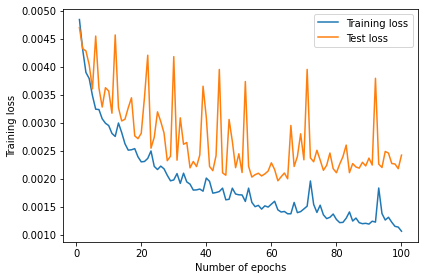

In [16]:
plt.plot(range(1,num_epochs+1),trainloss,label='Training loss')
plt.plot(range(1,num_epochs+1),testloss,label='Test loss')
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.legend()
plt.tight_layout()
plt.savefig('loss.png')
plt.show()


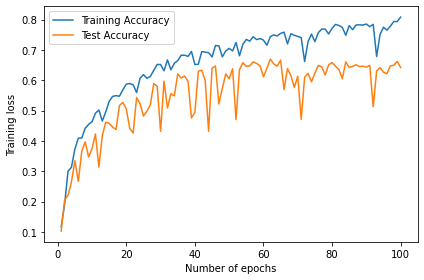

In [17]:
plt.plot(range(1,num_epochs+1),trainaccuracy,label='Training Accuracy')
plt.plot(range(1,num_epochs+1),testaccuracy,label='Test Accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.legend()
plt.tight_layout()
plt.savefig('accuracy.png')
plt.show()


##### Save the trained model

In [18]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

##### Load the trained model for validation

In [19]:
nett = Net()
nett.load_state_dict(torch.load(PATH))

<All keys matched successfully>

##### Load the test data into the model

In [20]:
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = nett(images)

##### Compare the ground truth vs Prediction

Ground Truth : Predicted 


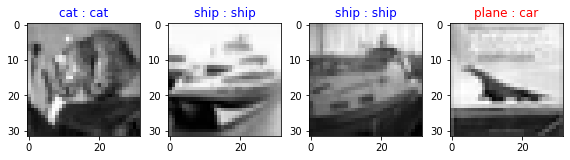

In [21]:


_, predicted = torch.max(outputs, 1)

# print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
#                               for j in range(6)))
print("Ground Truth : Predicted " )
fig = plt.figure(figsize=(8,8))

for i in range(4):
    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(images[i][0],  cmap = 'gray')#cmap = plt.cm.bone)
    if (classes[labels[i]] == classes[predicted[i]]):
        colr='b'
    else:
        colr='r'
    ax.set_title(str(classes[labels[i]]+" : "+classes[predicted[i]]),color=colr)
plt.tight_layout()
plt.savefig('predict_images.png')
plt.show()


##### Check Accuracy of the netwrok

In [22]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = nett(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


##### Cheeck the accuracy of each class in the dataset

In [23]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = nett(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %  [{correct_count}/{total_pred[classname]}]')

Accuracy for class: plane is 71.7 %  [717/1000]
Accuracy for class: car   is 86.2 %  [862/1000]
Accuracy for class: bird  is 33.1 %  [331/1000]
Accuracy for class: cat   is 43.2 %  [432/1000]
Accuracy for class: deer  is 58.9 %  [589/1000]
Accuracy for class: dog   is 52.0 %  [520/1000]
Accuracy for class: frog  is 59.5 %  [595/1000]
Accuracy for class: horse is 83.5 %  [835/1000]
Accuracy for class: ship  is 77.4 %  [774/1000]
Accuracy for class: truck is 70.6 %  [706/1000]


##### plot the Confusion matrix of the predicted score

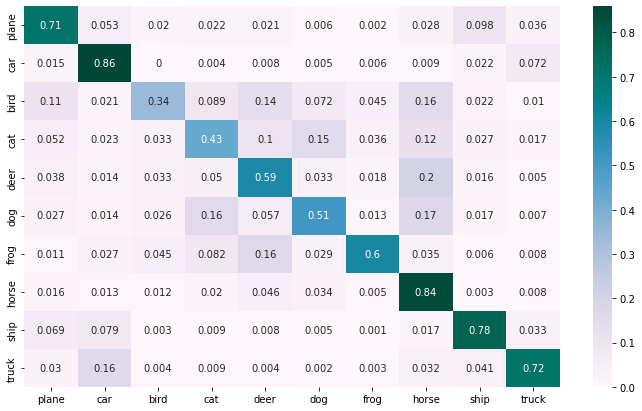

In [24]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import seaborn as sns
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
        output = nett(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True,cmap="PuBuGn")#cmap="YlGnBu")
plt.savefig('Confusionmatrix_cifar-10.png')




##### classification report of the data

In [25]:
cr = classification_report(y_true, y_pred, target_names=classes)
print(cr)


              precision    recall  f1-score   support

       plane       0.66      0.71      0.69      1000
         car       0.68      0.86      0.76      1000
        bird       0.66      0.34      0.45      1000
         cat       0.49      0.43      0.46      1000
        deer       0.52      0.59      0.55      1000
         dog       0.60      0.51      0.55      1000
        frog       0.82      0.60      0.69      1000
       horse       0.52      0.84      0.64      1000
        ship       0.75      0.78      0.77      1000
       truck       0.79      0.72      0.75      1000

    accuracy                           0.64     10000
   macro avg       0.65      0.64      0.63     10000
weighted avg       0.65      0.64      0.63     10000



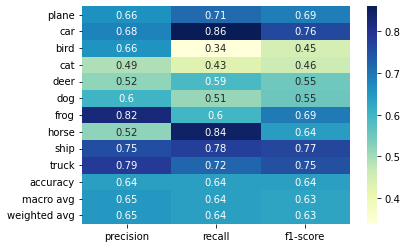

In [26]:
cr = classification_report(y_true, y_pred, target_names=classes,output_dict=True)
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True, cmap='YlGnBu')
plt.savefig('classification_report.png')

### end